## NeRF: representing scenes as neural radiance fields for view synthesis

Original Paper: [NeRF: representing scenes as neural radiance fields for view synthesis](https://arxiv.org/abs/2003.08934)
, 2022

NeRF is a method that generates synthesizing novel views of complex scenes by optimizing a sparse set of input views. It is carried out by a fully connected deep network denoted as m, whose input is a single continuous 5D coordinate (location ($x,y,z$) and viewing direction ($\theta, \phi)$) and whose output is the volume density ($\sigma$) and view-dependent emitted radiance ($RGB$) at that spatial location. 
$$
[\sigma,R,G,B]=m([x, y, z, \theta, \phi];\Phi)
$$

![nerf](illustration_nerf.png)

This neural radiance field represents a scene as the volumne density and directional emitted radiance at any point in space. Given the location and direction of the virtual camera, rendering a 2D image from this model requires estimating the integral $C(r)$ for a camear ray traced through each pixel. This integral consists of volume density $\sigma$, transmittance $T(t)$ and particle on camera ray. 
$$
    C(r)=\int_{t_n}^{t_f}T(t)\sigma(r(t))c(r(t),d)dt,\quad where \quad T(t)=exp(-\int_{t_n}^{t_f}\sigma(r(s))ds)
$$

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

### Q1: How do we generate input and ground true for supervise learning?

![overview_nerf](nerf_overview.png)

Given set of images, algorithms such as structure-from-motion (COLMAP) can estimate camera poses, intrinsics and bouds. With these parameters, pixel RGB values its corresponding camera poses, view direction are stored as target y and input x, respectively.
For example, an image (2x2) generate 4 training samples: 
$$
\begin{bmatrix}
xc & yc & zc & \theta_1 & \phi_1 & R1 & G1 & B1 \\
xc & yc & zc & \theta_2 & \phi_2 & R2 & G2 & B2 \\
xc & yc & zc & \theta_3 & \phi_3 & R3 & G3 & B3 \\
xc & yc & zc & \theta_4 & \phi_4 & R4 & G4 & B4 
\end{bmatrix}
$$
The following code demonstrate few examples from the training dataset and the first image

In [2]:
training_dataset = torch.from_numpy(np.load('../datasets/training_data_800x800.pkl',allow_pickle=True))
testing_dataset = torch.from_numpy(np.load('../datasets/testing_data_800x800.pkl',allow_pickle=True))

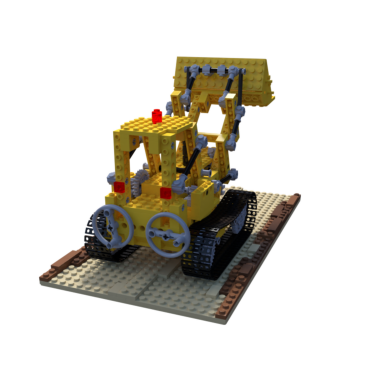

First 4 training samples camera position, viewing direction expressed as a 3D Cartesian unit:
 tensor([[-0.0538,  3.8455,  1.2081,  0.3340, -0.9418,  0.0390],
        [-0.0538,  3.8455,  1.2081,  0.3333, -0.9420,  0.0390],
        [-0.0538,  3.8455,  1.2081,  0.3326, -0.9423,  0.0390],
        [-0.0538,  3.8455,  1.2081,  0.3319, -0.9425,  0.0390]])


In [3]:
#image size
H, W=800, 800
img_index = 1

#display few samples from the training dataset
img_data = training_dataset[img_index * H * W: (img_index + 1) * H * W, 6:]  
img = img_data.reshape(H,W,3)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"First 4 training samples camera position, viewing direction expressed as a 3D Cartesian unit:\n {training_dataset[:4,:6]}")

### Q2: How to render (predict) a new image with given position and view direction of camera?
The output of model is not directly the color of each pixel, it is the density and color at 3D spatial position. To project 3D radiant onto a 2D image, rendering algorithm is applied. As illustrated in figure 2, discretilization is needed to numerically estiamte equation 1. This invloves queried several points on the ray and limit the speed of rendering. We can see better methods to do volume rendering. Here we desmonstrate the original one proposed by the paper: partition $[t_n, t_f]$ into N evenly spaced bins and then draw one sample $t_i$ uniformly at random from within each bin.

$$
t_i \sim u\left[t_n + \frac{i-1}{N}(t_f - t_n),\;\; t_n + \frac{i}{N}(t_f - t_n)\right]
$$

In [4]:
hn=0
hf=0.5
nb_bins=10

ray_origins = training_dataset[img_index * H * W: (img_index + 1) * H * W, :3][0]
ray_directions = training_dataset[img_index * H * W: (img_index + 1) * H * W, 3:6][0]

t = torch.linspace(hn, hf, nb_bins).expand(ray_origins.shape[0], nb_bins)
# Perturb sampling along each ray.
mid = (t[:, :-1] + t[:, 1:]) / 2.
lower = torch.cat((t[:, :1], mid), -1)
upper = torch.cat((mid, t[:, -1:]), -1)
u = torch.rand(t.shape)
t = lower + (upper - lower) * u  # [batch_size, nb_bins]
delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10],).expand(ray_origins.shape[0], 1)), -1)

x = ray_origins.unsqueeze(1) + t * ray_directions.unsqueeze(1)  
print(f"Sampled 3D points along a ray:\n {x.transpose(1,0)}")


Sampled 3D points along a ray:
 tensor([[-1.3933,  3.5437,  1.2890],
        [-1.3580,  3.4976,  1.2900],
        [-1.3287,  3.4906,  1.2911],
        [-1.3027,  3.4096,  1.2924],
        [-1.2549,  3.3756,  1.2936],
        [-1.2270,  3.3432,  1.2938],
        [-1.1996,  3.3044,  1.2951],
        [-1.1456,  3.2722,  1.2963],
        [-1.0990,  3.2222,  1.2975],
        [-1.0841,  3.1815,  1.2983]])


Estimating C(r) with quadrature rule is given as:

$$
\hat{C}(r)=\sum_{i=1}^{N}T_i(1-\exp{(-\sigma_i \delta_i)})c_i \\
T_i=\exp{(-\sum_{j=1}^{i-1}\sigma_j \delta_j)},
$$

where $\delta_i=t_{i+1}-t_i$ is the distance between adjacent samples
This function can reduces to traidtional alpha compositing with alpha values:
$$
\alpha_i=1-\exp{(-\sigma_i \delta_i)} \\
\hat{C}(r)=\sum_{i=1}^{N} T_i \alpha_i c_i 
$$

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

L = 16
F = 2
T = 2**19
N_min = 16
N_max = 2048
b = np.exp((np.log(N_max) - np.log(N_min)) / (L - 1))
Nl = [int(np.floor(N_min * b**l)) for l in range(L)]

In [6]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):
    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(ray_origins.shape[0], nb_bins)
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2.
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor(
        [1e10], device=device).expand(ray_origins.shape[0], 1)), -1)

    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)
    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1)
    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    alpha = 1 - torch.exp(-sigma.reshape(x.shape[:-1]) * delta)  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    c = (weights * colors.reshape(x.shape)).sum(dim=1)
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1)

Positioning encoding is applied to 5D input in order to represent high-frequency variation in color and geometry. 
The authors designed separate MLPs to predict density and emitted color. The first MLP predicts the volume density as a function of only the location x, while allowing the RGB color c to be predicted as a function of both location and viewing direction. Now we pack all these functions into NerfModel class

In [21]:
class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim=128):   
        super(NerfModel, self).__init__()
        
        self.block1 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )
        # density estimation
        self.block2 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + hidden_dim + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1), )
        # color estimation
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2), nn.ReLU(), )
        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(o, self.embedding_dim_pos) # emb_x: [batch_size, embedding_dim_pos * 6]
        emb_d = self.positional_encoding(d, self.embedding_dim_direction) # emb_d: [batch_size, embedding_dim_direction * 6]
        h = self.block1(emb_x) # h: [batch_size, hidden_dim]
        tmp = self.block2(torch.cat((h, emb_x), dim=1)) # tmp: [batch_size, hidden_dim + 1]
        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1]) # h: [batch_size, hidden_dim], sigma: [batch_size]
        h = self.block3(torch.cat((h, emb_d), dim=1)) # h: [batch_size, hidden_dim // 2]
        c = self.block4(h) # c: [batch_size, 3]
        return c, sigma

To understand the use of NeRF in rendering scene, here we load a trained NeRF model and run the test images for demonstration. You can run nerf.py directly to train one and it will generate nerf_model.pth file

/home/seawi/miniconda3/envs/gpu_env/lib/python3.13/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


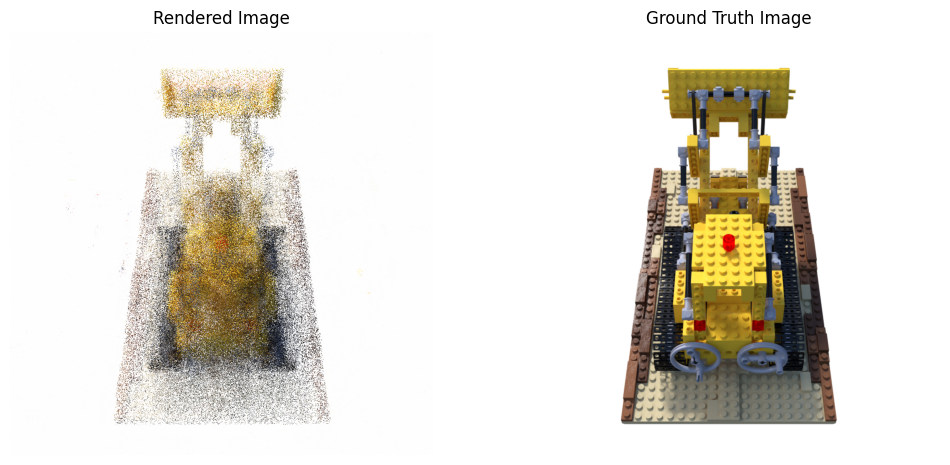

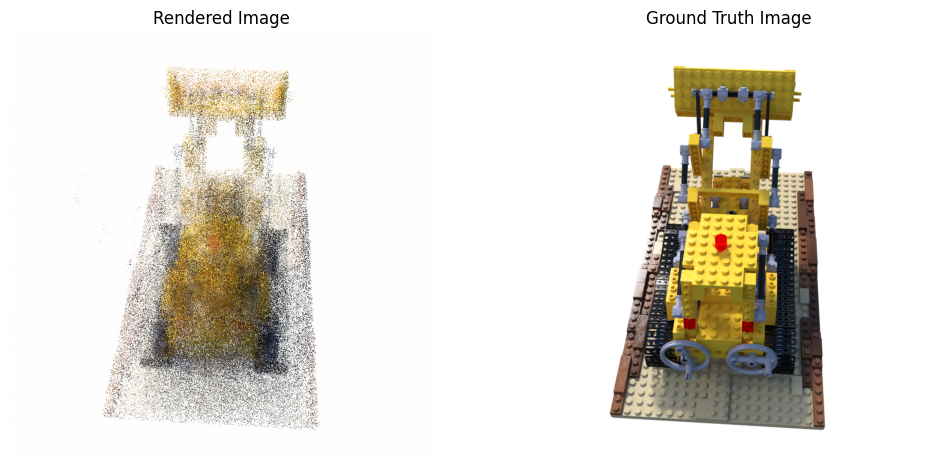

In [ ]:
from nerf import NerfModel

#load model to estimate density and color at 3D spatial position
model = NerfModel(hidden_dim=256).to(device)
model.load_state_dict(torch.load('../models/nerf_model.pth'))
model.eval()
model.to(device)

hn,hf=2,6
chunk_size=20
for img_index in range(2):
    ray_origins = testing_dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = testing_dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    px_values = []   # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        px_values.append(render_rays(model, ray_origins_, ray_directions_,
                                     hn=hn, hf=hf, nb_bins=nb_bins))
    img = torch.cat(px_values).data.cpu().numpy().reshape(H, W, 3)
    img = (img.clip(0, 1)*255.).astype(np.uint8)
    img_rendered = Image.fromarray(img)


    # Ground truth image from testing_dataset
    img_gt = testing_dataset[img_index * H * W : (img_index + 1) * H * W, 6:]
    img_gt = img_gt.reshape(H, W, 3)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img_rendered)
    axes[0].set_title("Rendered Image")
    axes[0].axis('off')

    axes[1].imshow(img_gt)
    axes[1].set_title("Ground Truth Image")
    axes[1].axis('off')

    plt.show()

### Q3: What are the issue of original NeRF?
- input design: even with positiong encodeing to catch higher frequency feature, this model has difficult time catch mutltlevel of resolution 
- speed: it converge very slowly with this size of MLP. (hours)
- MLP design:compared to other NeRF-based methods, MLPs are larger and inference time is long
- scenes limitation: these are tested and design for object-centric scenes, therefore, unbounded scenes will not have good results.
- Robustness: the position and view angles have to stable and wide ranges. For free motion trajectories with variations of the observation distance while avoiding aliasing artefacts are weak in this 'vanilla' NeRF.
- Extensibility: lack of the ability to process incremental input (extensibility in the number of view) and adptive process (extensibility in resolution)

We will see the solutions in other notebooks.

In [20]:
num_params = sum(p.numel() for p in model.parameters())
print(f"NeRF model parameter size: {num_params:,}")
print(model.parameters)

NeRF model parameter size: 16,787,539
<bound method Module.parameters of NGP(
  (lookup_tables): ParameterDict(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 524288x2 (cuda:0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 524288x2 (cuda:0)]
      (10): Parameter containing: [torch.cuda.FloatTensor of size 524288x2 (cuda:0)]
      (11): Parameter containing: [torch.cuda.FloatTensor of size 524288x2 (cuda:0)]
      (12): Parameter containing: [torch.cuda.FloatTensor of size 524288x2 (cuda:0)]
      (13): Parameter containing: [torch.cuda.FloatTensor of size 524288x2 (cuda:0)]
      (14): Parameter containing: [torch.cuda.FloatTensor of size 524288x2 (cuda:0)]
      (15): Parameter containing: [torch.cuda.FloatTensor of size 524288x2 (cuda:0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 524288x2 (cuda:0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 524288x2 (cuda:0)]
      (4): Parameter containing: [torch.cu